# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [1]:
import re
import pandas as pd
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Download the Dataset

In [2]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
100% 213k/213k [00:00<00:00, 357kB/s]
100% 213k/213k [00:00<00:00, 357kB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


In [3]:
df = pd.read_csv('/content/spam.csv')

# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [4]:
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.isna().sum()

,0
text,0
label,0


In [7]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [8]:
df['text'].sample()

,text
3256,"No, but you told me you were going, before you..."


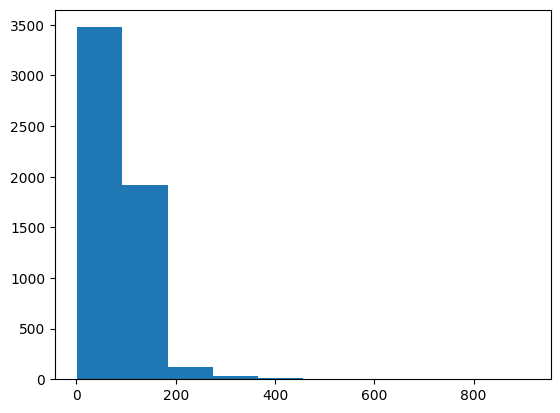

In [9]:
# Text Data Characteristics
df['text_length'] = df['text'].apply(len)
plt.hist(df['text_length'])
plt.show()

In [10]:
# Maximum text length
df['text'].str.len().max()

910

In [11]:
# Minimum text length
df['text'].str.len().min()

2

In [12]:
# Common Words and Vocabulary
texts = ' '.join(df['text'].values)
words = texts.split()
words_counts = Counter(words)
common_words = words_counts.most_common(10)

print("most frequent words:", common_words)

most frequent words: [('to', 2134), ('you', 1622), ('I', 1466), ('a', 1327), ('the', 1197), ('https://link1.com', 958), ('https://link3.com', 916), ('https://link2.com', 910), ('and', 857), ('in', 798)]


# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [13]:
max_length = 200
min_length = 20

df = df[df['text'].str.split().str.len().between(min_length, max_length)]

In [14]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [15]:
def clean_text(text):
    # Remove links (URLs)
    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove special characters and punctuations
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    # Lowercasing
    cleaned_text = text.lower()
    # Remove English stopwords
    filtered_words = ' '.join([word for word in words if word not in stop_words])
    # Apply stemming to the text
    cleaned_text = ' '.join([lemmatizer.lemmatize(word) for word in cleaned_text.split()])

    return cleaned_text

In [16]:
# Apply the clean_text function to the feature column
df['cleaned_text'] = df['text'].apply(clean_text)

In [17]:
df['cleaned_text'].head()

,cleaned_text
0,"go until jurong point, crazy.. available only ..."
2,free entry in 2 a wkly comp to win fa cup fina...
5,freemsg hey there darling it's been 3 week's n...
7,a per your request 'melle melle (oru minnaminu...
8,winner!! a a valued network customer you have ...


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])

# Text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
# Padding the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Label encoding
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(df['label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_label, test_size=0.2, random_state=42)

In [19]:
# Data shape confirmation
print("Shape of Training data: ",X_train.shape)
print("Shape of Training labels: ",y_train.shape)
print("Shape of Testing data: ",X_test.shape)
print("Shape of Testing labels: ",y_test.shape)

Shape of Training data:  (1430, 200)
Shape of Training labels:  (1430,)
Shape of Testing data:  (358, 200)
Shape of Testing labels:  (358,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [33]:
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 128)            │         799,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 842,561 (3.21 MB)

 Trainable params: 842,561 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [34]:
batch_size = 32

# Create a TensorFlow Dataset from the training data
train_dataset = tensorflow.data.Dataset.from_tensor_slices((X_train, y_train))
# Create a TensorFlow Dataset from the testing data
test_dataset = tensorflow.data.Dataset.from_tensor_slices((X_test, y_test))
# Batching the Datasets
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
# Train the Model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6404 - loss: 0.6108 - val_accuracy: 0.9581 - val_loss: 0.2662
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9717 - loss: 0.1462 - val_accuracy: 0.9609 - val_loss: 0.1007
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9892 - loss: 0.0377 - val_accuracy: 0.9469 - val_loss: 0.1229
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9988 - loss: 0.0130 - val_accuracy: 0.9581 - val_loss: 0.1075
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9804 - val_loss: 0.0974
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9804 - val_loss: 0.1059
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 6.3758e-04 - val_accuracy: 0.9777 - val_loss: 0.1116
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 4.7436e-04 - val_accuracy: 0.

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [35]:
results = model.evaluate(test_dataset)
print(f"Accuracy: {results[1] * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9847 - loss: 0.0831
Accuracy: 97.49%


### Visualization

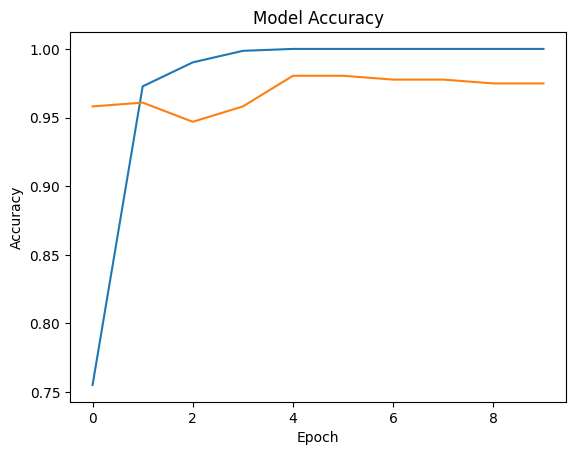

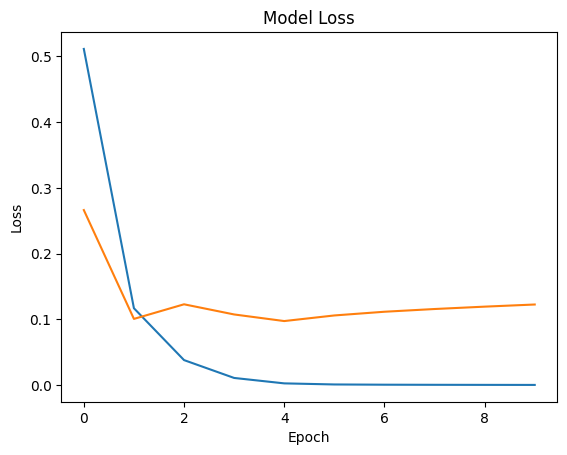

In [36]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [37]:
sample_text = ["This is a Good Text Classification Exam"]
sample_sequence = tokenizer.texts_to_sequences([clean_text(sample_text[0])])
padded_sample_sequence = pad_sequences(sample_sequence, maxlen=max_length, padding='post')

predicted_label = model.predict(padded_sample_sequence)

print("Predicted label:", label_encoder.inverse_transform([predicted_label.argmax()]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Predicted label: ['ham']


In [38]:
model.save('model.h5')

# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:
- I handle the text with remove (links, special characters and punctuations, English stopwords), also convert the text to lower case and Apply stemming to the text.

- I use a simple Architecture ,To see if the results are excellent, and if not, then I will increase the complexity of the model

- As I said, To see first if the results are excellent, and if not, then I will increase the complexity of the model by added more layers.

- I want to see accuracy if the model went to be good or not.

- It is work successful because validation accuracy It have a good value and visualization dosen't shows any overfitting or underfitting.

- If there overfitting or underfitting, maybe I add drop out layers, or Early stop to avoid it.